In [2]:
import numpy as np
import librosa
from scipy.signal import get_window
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 5)

#### "Import" some functions from Exercise 1 (using an ugly hack)

In [3]:
import requests

gist = requests.get(
    "https://gist.githubusercontent.com/iibrahimli/3c50f73020c78aeee1de68ae5a0ba5e7/raw/import_funcs.py"
).text
print("Downloaded import_funcs.py")
exec(gist)

import_function_from_ipynb(
    "exercise1.ipynb",
    [
        "my_windowing",
        "acf",
        "estimate_fundamental_frequency",
        "plot_signal",
    ],
)


Downloaded import_funcs.py
Found exercise1.ipynb: C:\Users\Natia_Mestvirishvili\OneDrive - EPAM\Desktop\UHH\SSP\ssp_sose2023\Exercise1\exercise1.ipynb
Executed function plot_signal
Executed function my_windowing
Executed function acf
Executed function estimate_fundamental_frequency
Successfully imported functions: ['plot_signal', 'my_windowing', 'acf', 'estimate_fundamental_frequency']


In [4]:
my_windowing, acf, estimate_fundamental_frequency

(<function __main__.my_windowing(v_signal: numpy.ndarray, sampling_rate: int, frame_length: int, frame_shift: int = None) -> tuple[numpy.ndarray, numpy.ndarray]>,
 <function __main__.acf(frames)>,
 <function __main__.estimate_fundamental_frequency(acf_frames: numpy.ndarray, sampling_freq: int, min_freq: float = 80, max_freq: float = 400) -> numpy.ndarray>)

## 1. Short-time Fourier Transform

In [5]:
def compute_stft(
    v_signal: np.ndarray,
    fs: int,
    frame_length: int,
    frame_shift: int,
    v_analysis_window: np.ndarray,
) -> list[np.ndarray]:
    """Compute the short-time Fourier transform of a signal."""
    frames, frame_centers = my_windowing(v_signal, fs, frame_length, frame_shift)
    frames *= v_analysis_window
    spectrum = np.fft.fft(frames, axis=1)
    # remove upper half of the spectrum
    spectrum = spectrum[:, : spectrum.shape[1] // 2 + 1]

    # check with np.fft.rfft
    spectrum2 = np.fft.rfft(frames, axis=1)
    print("Output matches np.fft.rfft:", np.allclose(spectrum, spectrum2))
    # Throw exception if outputs don't match
    np.testing.assert_array_almost_equal(spectrum, spectrum2)

    return spectrum, frame_centers

In [6]:
s1, sampling_rate = librosa.core.load("Audio/speech1.wav", sr=None)
print(len(s1) / sampling_rate, "s")

s2, sampling_rate = librosa.core.load("Audio/phone.wav", sr=None)
print(len(s2) / sampling_rate, "s")

2.841625 s
2.0 s


In [7]:
m_stft, frame_centers = compute_stft(s1, sampling_rate, 25, 10, np.hamming(25 * sampling_rate // 1000))

Output matches np.fft.rfft: True


If a signal has complex conjugate symmetry, it means that the real part of the signal function is even and the imaginary part is odd, meaning real parts are identical and imaginary parts are negative of each-other. If we demonstrate a DFT coefficient on a complex plane, the arrow length corresponds to the magnitude and the angle between the arrow and the real axis corresponds to the phase. If we traverse the circle clockwise or counterclockwise, we get the same amplitude (same phase, opposite signs), therefore by finding DFT coefficients for all frequencies starting from 0 to the sampling rate, we get a symmetric output. 

By only considering half of the output spectrum, we get rid of the redundancy and increase the performance.

After removing the mirrored part, we are left with (sampling rate / 2 + 1) samples. 

## 2. Spectral analysis

### a) Log magnitude spectrogram

In [14]:
def plot_log_spectrogram(
    signal: np.ndarray,
    sampling_rate: int,
    frame_length: int = 32,
    frame_shift: int = 8,
    threshold: float = None,
    plt_show: bool = True,
) -> None:
    """Plot the log spectrogram of a signal."""
    m_stft, v_time = compute_stft(
        signal,
        sampling_rate,
        frame_length,
        frame_shift,
        get_window("hann", frame_length * sampling_rate // 1000),
    )

    magnitude = 10 * np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10 ** (-15)))

    v_freq = np.linspace(0, sampling_rate / 2, magnitude.shape[0])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(
        magnitude,
        cmap="viridis",
        origin="lower",
        extent=[v_time[0], v_time[-1], v_freq[0], v_freq[-1]],
        aspect="auto",
    )

    if threshold is not None:
        # plot parts of the spectrogram that are above the threshold
        ax.contour(
            v_time,
            v_freq,
            magnitude,
            levels=[threshold],
            colors="red",
            linestyles="solid",
            linewidths=1,
        )

    fig.colorbar(im, orientation="vertical", pad=0.01)
    im.colorbar.set_label("Magnitude [dB]", rotation=270, labelpad=15)

    ax.set_title(f"Spectrogram \n (frame length: {frame_length} ms, frame shift: {frame_shift} ms)")
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Frequency [Hz]")
    # ax.set_yscale("log")

    fig.tight_layout()
    if plt_show:
        plt.show()

Magnitude is plotted in dB, since it is a logarithmic unit used to measure sound level and we use formula 10 log (X) to convert the magnitudes to decibels. Lower limit given in the command is -150 dB,  which helps us ignore insignificant magnitudes.

Output matches np.fft.rfft: True


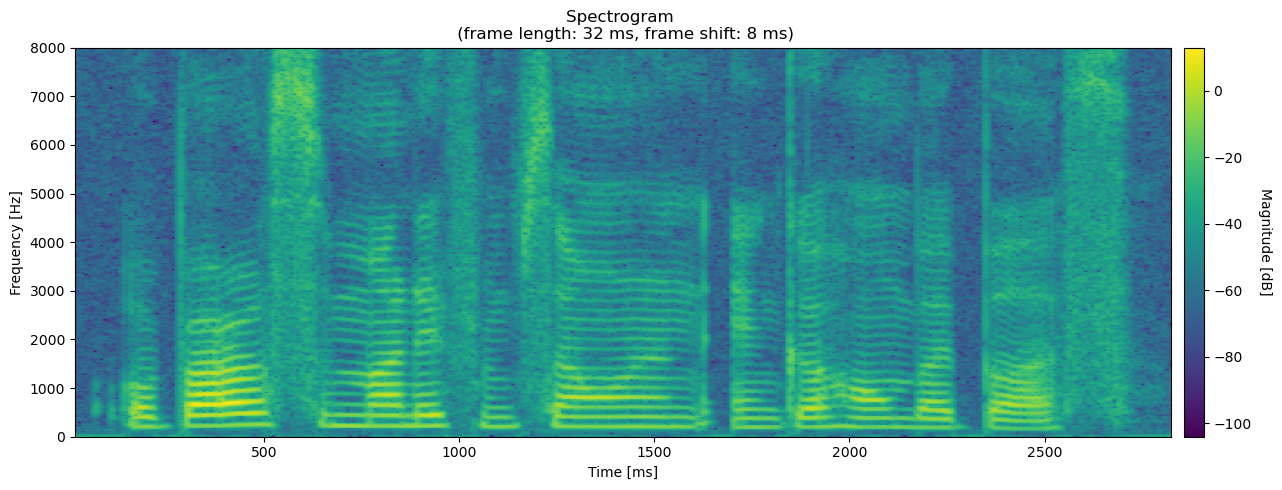

In [15]:
plot_log_spectrogram(s1, sampling_rate, frame_length=32, frame_shift=8)

Output matches np.fft.rfft: True


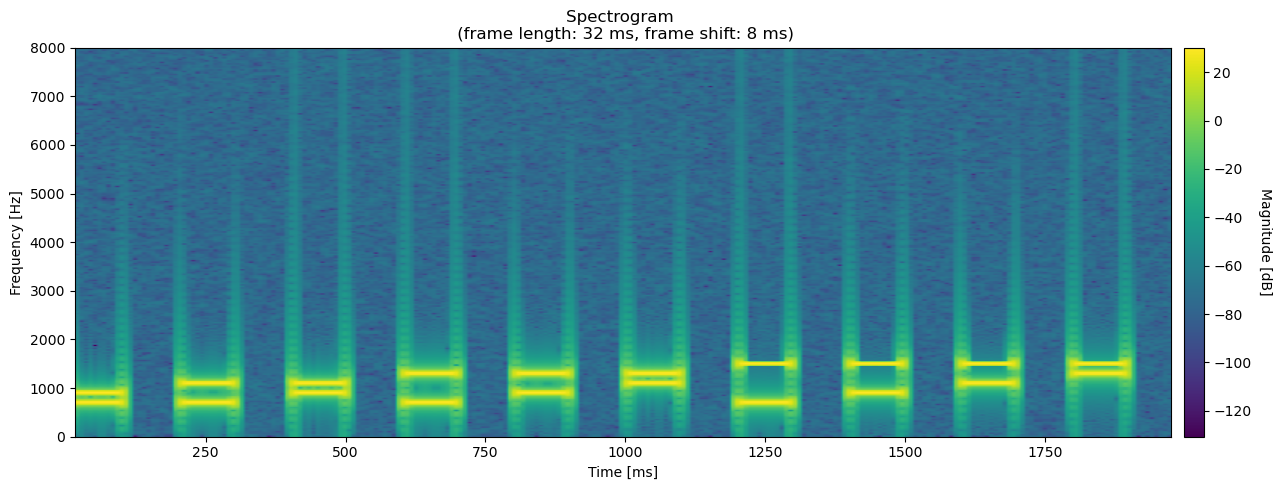

In [16]:
plot_log_spectrogram(s2, sampling_rate, frame_length=32, frame_shift=8)

### b) Identify the voiced, unvoiced and silence segments

Voiced sounds mean, there are vibrations in the vocal cords. Unvoiced – NO vibrations in the vocal cords. Silence is the absence of audible sound, on the decibel scale, near total silence is 0 dB. 

Voiced regions would have clearly defined formant bars, voiced regions can also show show aspects of both regular vocal fold vibrations and a randomly turbulent airstream. 

On a spectrogram, unvoiced regions will have a lot of random noise that looks like static, but through the static you can usually see the faint bands of the voiceless vowel's formants.

Source: https://home.cc.umanitoba.ca/~krussll/phonetics/acoustic/spectrogram-sounds.html

In the first speech:
Voiced region - 250-500 ms;
Unvoiced region - 50-250 ms;
Silent region - 500-750 ms

In the second speech:
Voiced region - 180-300 ms;
Unvoiced region - N/A;
Silent region - 300-400 ms

### c) Frame length = 8 ms, frame shift = 2 ms

Output matches np.fft.rfft: True


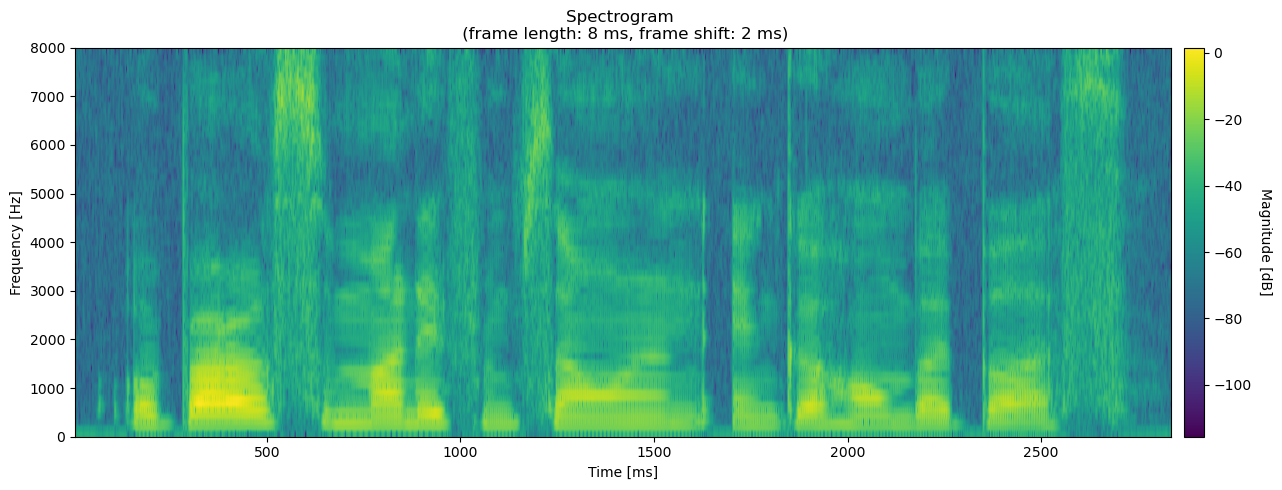

In [17]:
plot_log_spectrogram(s1, sampling_rate, frame_length=8, frame_shift=2)

Output matches np.fft.rfft: True


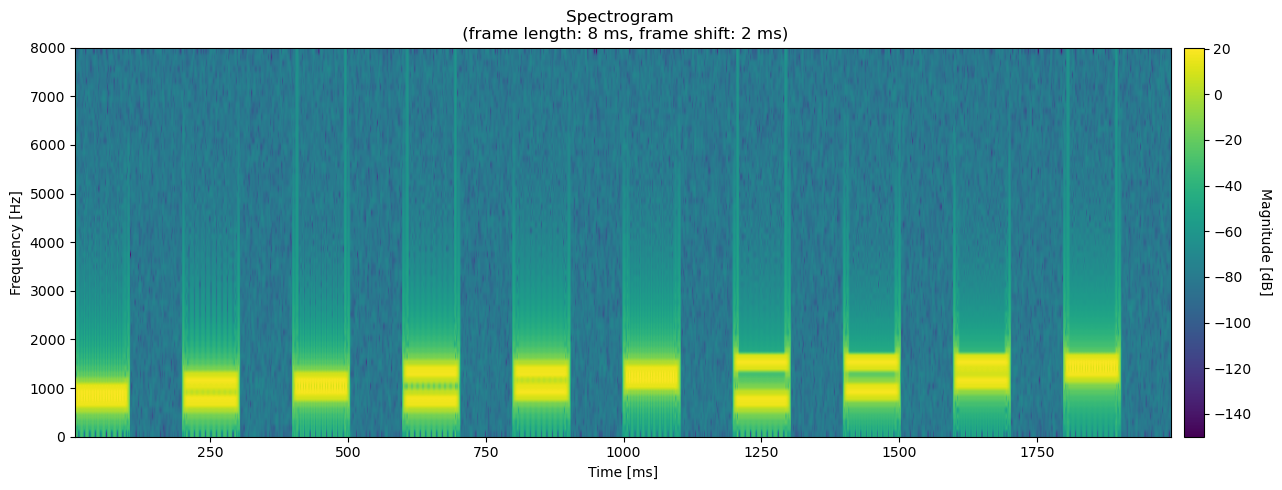

In [18]:
plot_log_spectrogram(s2, sampling_rate, frame_length=8, frame_shift=2)

### c) Frame length = 128 ms, frame shift = 32 ms

Output matches np.fft.rfft: True


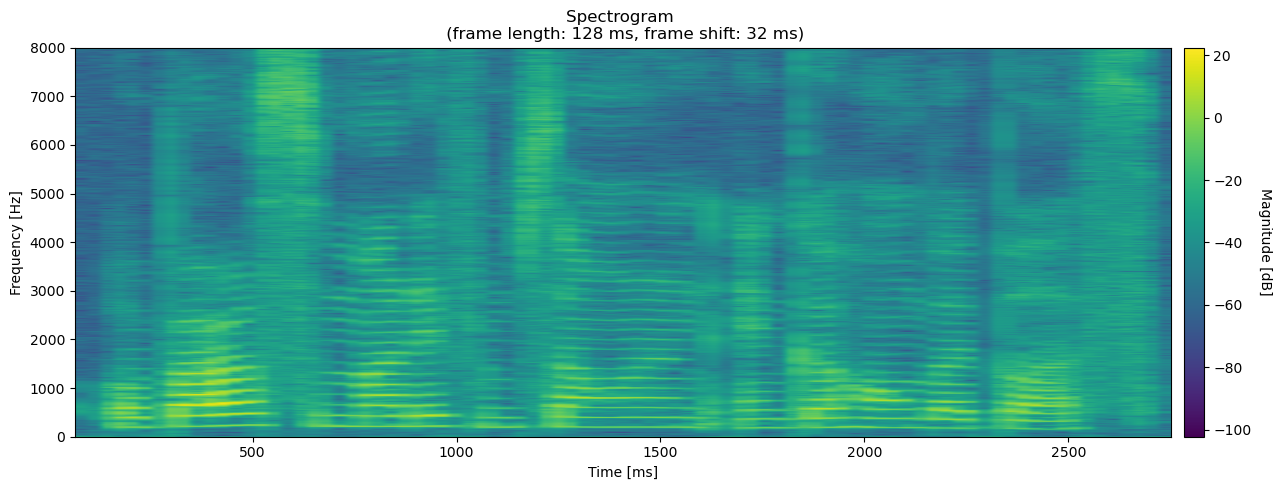

In [19]:
plot_log_spectrogram(s1, sampling_rate, frame_length=128, frame_shift=32)

Output matches np.fft.rfft: True


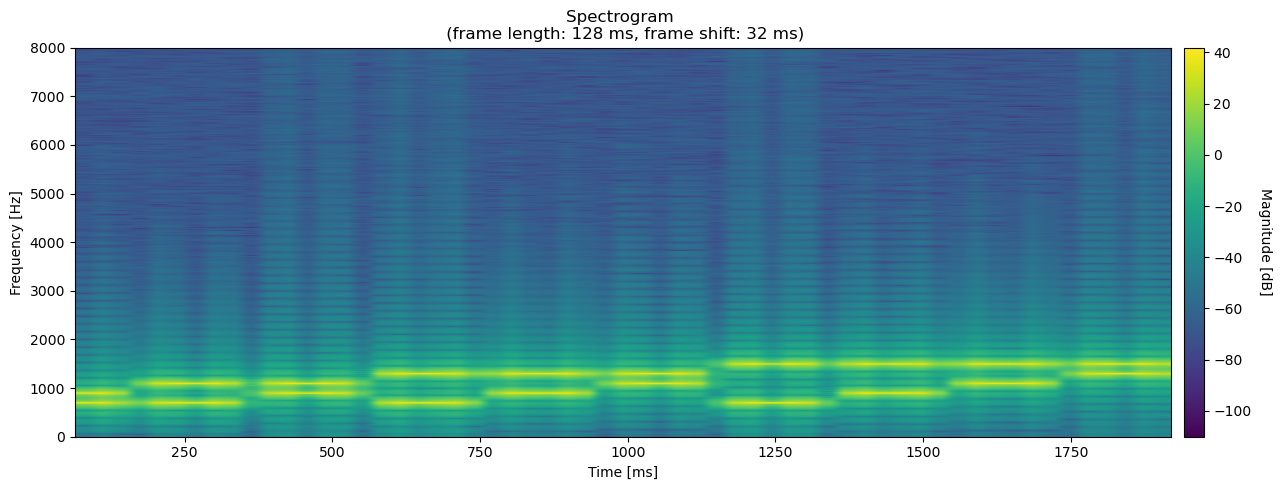

In [20]:
plot_log_spectrogram(s2, sampling_rate, frame_length=128, frame_shift=32)

We can observe the tradeoff between time and frequency resolution: longer frames (windows) give a better frequency resolution at the cost of decreased time resolution.

### d) Fundamental frequency

In [21]:
# compute fundamental frequency
frames, frame_centers = my_windowing(s1, sampling_rate, 32, 8)
acf_frames = acf(frames)
f0 = estimate_fundamental_frequency(acf_frames, sampling_freq=sampling_rate, min_freq=80, max_freq=400)
f0.shape

(352,)

Output matches np.fft.rfft: True


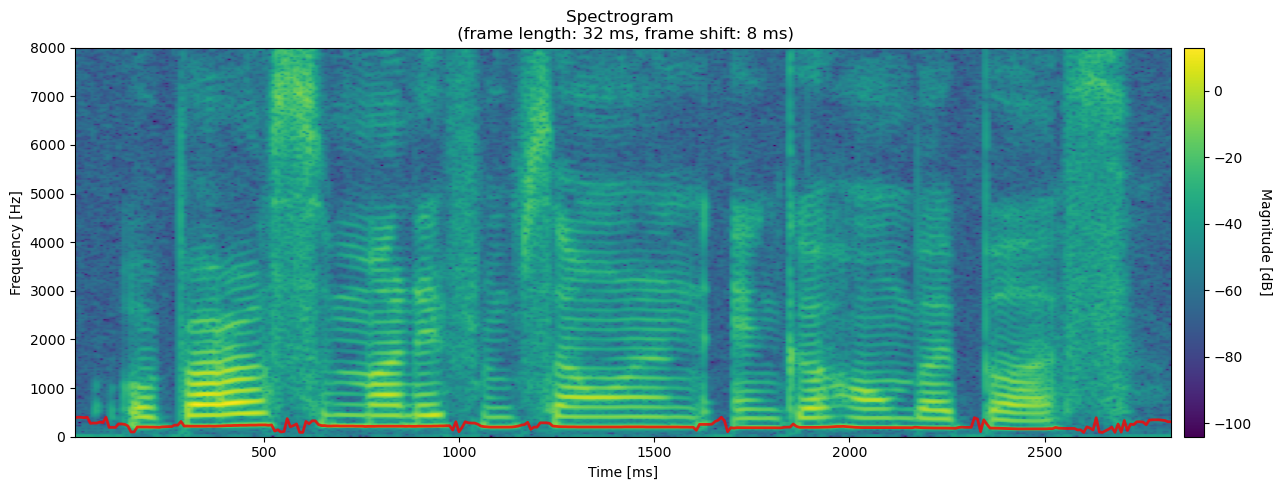

In [22]:
plot_log_spectrogram(s1, sampling_rate, frame_length=32, frame_shift=8, plt_show=False)

# plot fundamental frequency on top of spectrogram
n_harmonics = 1
for i in range(1, n_harmonics + 1):
    plt.plot(frame_centers, f0 * i, color="red", linewidth=2, alpha=0.8)

plt.show()

We can see the fundamental frequency (in red) matches the frequency of the first peak in the spectrum.

Output matches np.fft.rfft: True


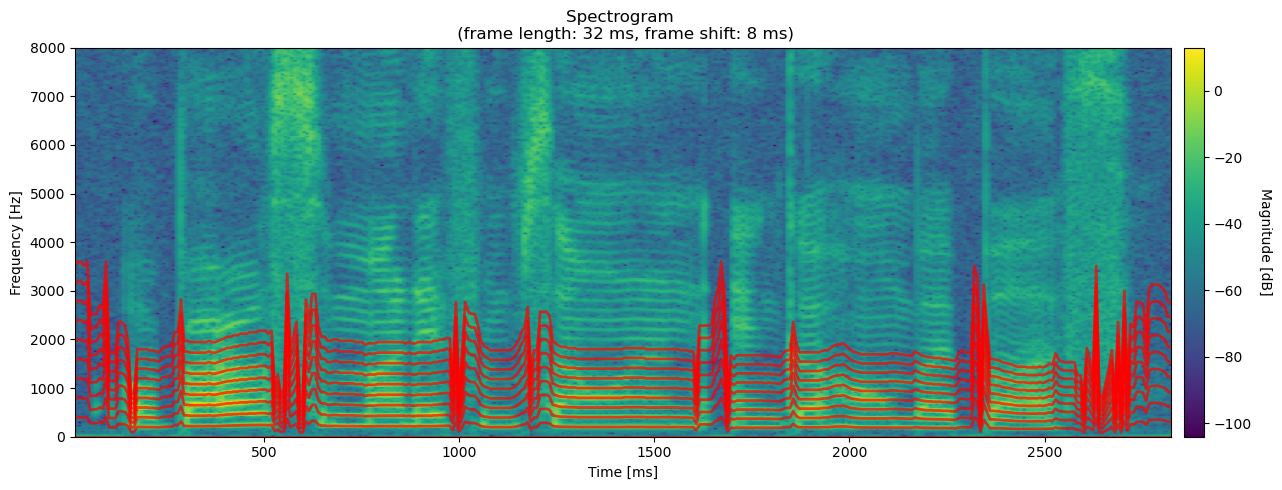

In [23]:
plot_log_spectrogram(s1, sampling_rate, frame_length=32, frame_shift=8, plt_show=False)

# plot fundamental frequency on top of spectrogram
n_harmonics = 10
for i in range(n_harmonics):
    plt.plot(frame_centers, f0 * i, color="red", linewidth=2, alpha=0.7)

plt.show()

With 10 harmonics plotted, the alignment between the peaks and the harmonics is not perfect, but it is still possible to see the harmonics.

## 3) Inverse STFT

In [1]:
from code_exercise2 import compute_istft

### Test signal

In [25]:
frame_length = 32
frame_shift = 16
sampling_rate = 16000

v_test_signal = np.ones(2048)

### 1. STFT of the test signal

In [75]:
sqrt_hann = np.sqrt(get_window("hann", frame_length * sampling_rate // 1000))

m_stft, frame_centers = compute_stft(v_test_signal, sampling_rate, frame_length, frame_shift, sqrt_hann)

Output matches np.fft.rfft: True


### 2. Resynthesis of the test signal

In [76]:
v_reconstructed_signal = compute_istft(m_stft, frame_length, frame_shift, sqrt_hann)
v_reconstructed_signal.shape

(512,)

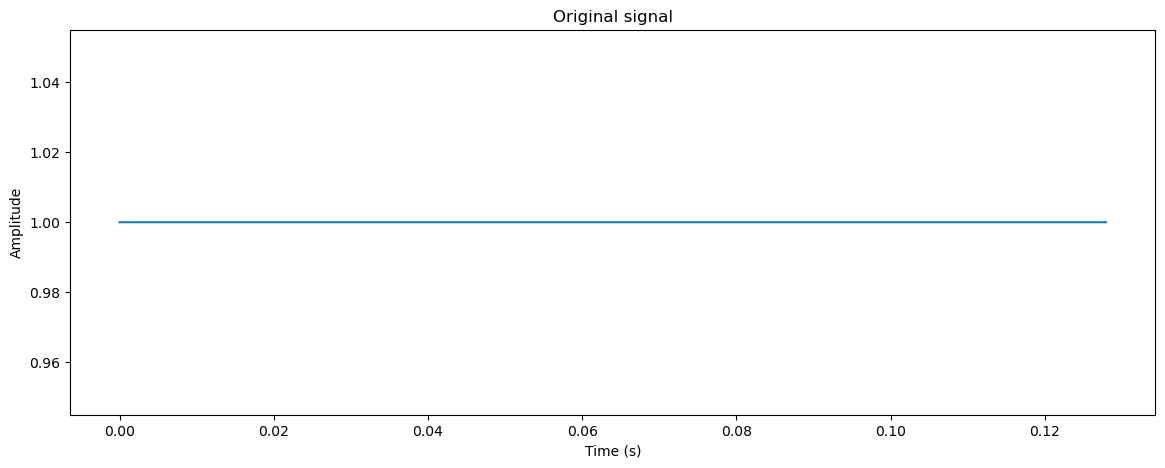

In [77]:
plot_signal(v_test_signal, sampling_rate, title="Original signal")

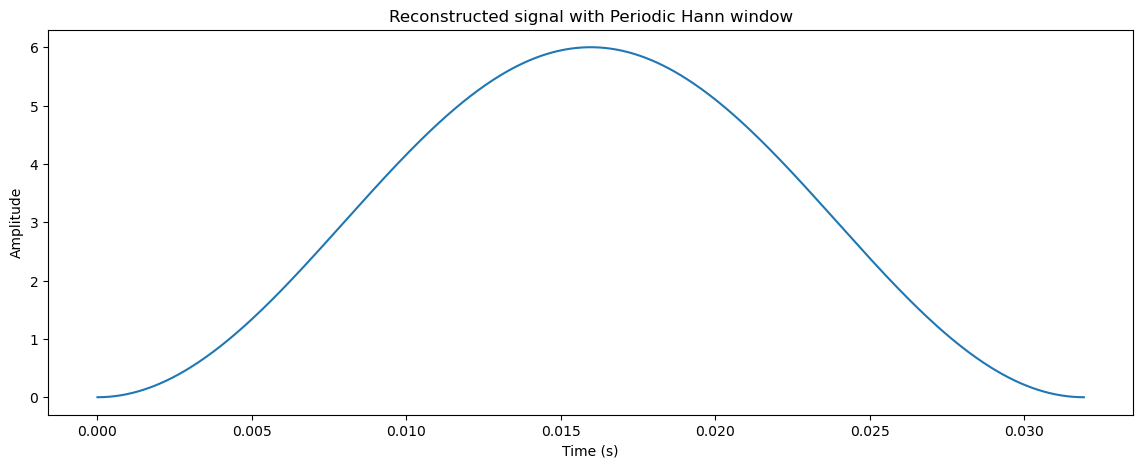

In [82]:
plot_signal(v_reconstructed_signal, sampling_rate, title="Reconstructed signal with Periodic Hann window")

> NOTE: the reconstructed signal has the length of 512, while the original has 2048 samples

#### Remove period from Hann window

Output matches np.fft.rfft: True


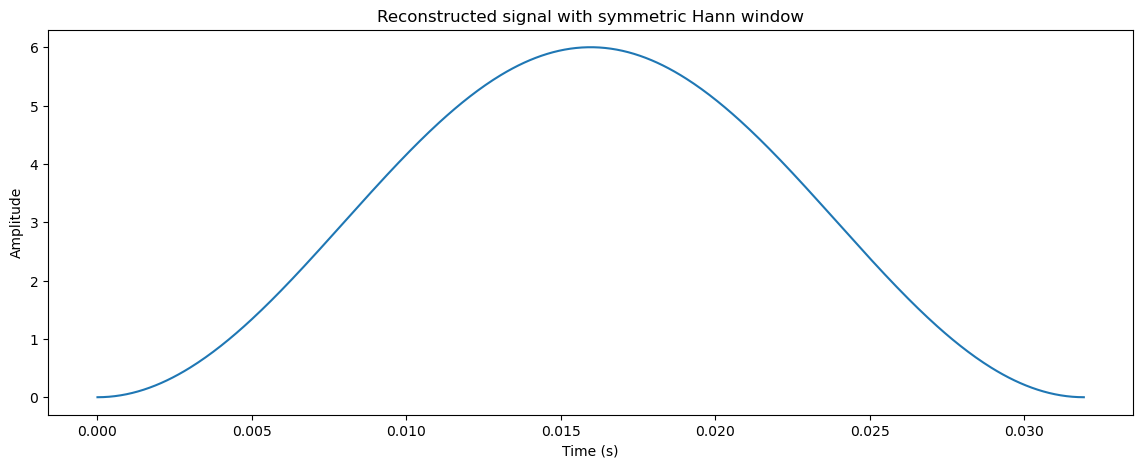

In [80]:
sqrt_hann = np.sqrt(get_window("hann", frame_length * sampling_rate // 1000, fftbins=False))

m_stft, frame_centers = compute_stft(v_test_signal, sampling_rate, frame_length, frame_shift, sqrt_hann)

v_reconstructed_signal_2 = compute_istft(m_stft, frame_length, frame_shift, sqrt_hann)

plot_signal(v_reconstructed_signal_2, sampling_rate, title="Reconstructed signal with symmetric Hann window")

Hann windows can by symmetric and periodic.

Symmetric Hann windows are  used in computer vision for smoothing filters.

Periodic Hann windows are useful in spectral analysis. They enable windowed signals to have periodic extension, which are useful for DFT. When 'periodic' is specified, hann computes a window of length L + 1 and returns the first L points.

Sources:
https://de.mathworks.com/help/signal/ref/hann.html
https://commons.wikimedia.org/wiki/File:8-point_Hann_windows.svg
